<a href="https://colab.research.google.com/github/decoz/mlclass/blob/master/ch9_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from keras.models import Sequential
from keras.layers import Dense

# GAN

GAN은 생산적 적대 신경망 ( Generative Adversarial Network ) 의 약자로서 다양한 딥 페이크 기술에 쓰인다. GAN은  진짜와 그럴듯이 보이는 가짜를 만들어내는  네트워크로서 경쟁 학습이라는 독특한 시스템을 사용한다. 

GAN에 필요한 요소는 다음과 같다. 

- 진짜 데이터 
- 가짜 데이터를 만드는 모방 신경망
- 생성된 데이터 진위 판별 신경망

GAN은 다음과 같은 과정을 세번의 과정을 통해 학습된다. 

1. 모방 신경망(generator)를 통해 가짜 데이터 생성 
2. 진짜 데이터와 가짜 데이터를 번갈아 진위판별망(discriminator)에 입력해 학습
3. 랜덤 데이터로 모방 신경망 학습 








<hr> 

## 가장 단순한 GAN 구성

이런 구조의 네트워크를 어떻게 구성해야 하는지 처음에는 언뜻 이해가 가지 안을 것이다.  이제부터 이것이 어떻게 작동하는 지 원리를 알아보기 위해 가장 단순한 형태의 GAN을 하나를 만들어보도록 하겠다. 





### 1. 모방할 데이터 모델

다음은 흔한 numpy 의 sin 관계를 갖는 데이터 생성코드이다.  


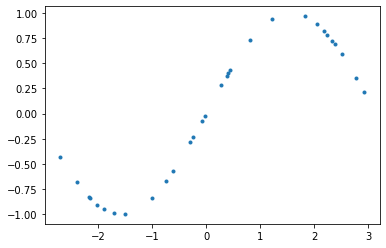

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 

x = (np.random.rand(30,1) - 0.5)*2.*np.pi # -pi ~ pi 까지 랜덤 생성
y = np.sin(x)    # y 는 x의 sin 함수 값

plt.plot(x,y,'.')
plt.show()


이제 위의 곡선이 우리가 모방하고 싶은 x,y 의 모임이라고 가정해보자. 이제 위의 곡선을 통해 모방 데이터를 생성하는 함수를 하나 정의하도록 하겠다.  아래의 함수 real 은 n개의 sin 에 위치한 점을 생성한다. 

주의할 점은 x 와 sin(x)가 같이 2차원 배열로 리턴되고 y 는 real 데이터를 의미하는 1 값으로 채워진다.  이것은 점 -> 진짜 or 가짜 판별을 위한 판별망에 학습데이터로 사용하기 위해서이다. 



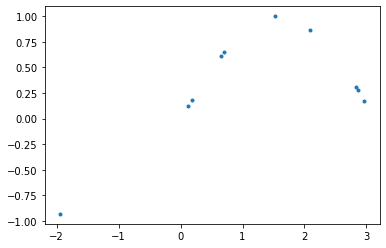

[[-1.94432444 -0.93104572]
 [ 0.11861465  0.11833671]
 [ 1.52886952  0.9991212 ]
 [ 0.18322966  0.18220611]
 [ 2.09657676  0.86493252]
 [ 2.86330942  0.27470533]
 [ 0.70315386  0.64662669]
 [ 2.82688879  0.30953489]
 [ 0.65393867  0.60831721]
 [ 2.96690702  0.17379856]] [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [3]:
def real(n):   
    x = (np.random.rand(n,1) - 0.5)*2.*np.pi
    x = np.hstack((x, np.sin(x)))
    y = np.ones((n, 1))
    return x,y

x,y = real(10)
plt.plot(x[:,0], x[:,1],'.')
plt.show()
print(x,y)

### 2. 모방 신경망 (generator)

 우리의 목표는 이 데이터를 만들어주는 모방 신경망(generator)이다.  이 망에서 입력은 어디까지나 데이터를 생성하기 위한 시드값일 뿐이며 타겟 데이터와는 연관이 없는 랜덤값을 사용한다. 요컨데 우리가 원하는 것은 

"아무 값이나 넣어도 sin 곡선안에 있는 한점을 만들어주는 신경망 "

이다. 점을 만들어주기 때문에 출력은 2차원이여야 하며 입력은 일종의 더미 데이터이기 때문에 임의의 크기로 자유롭게 구성할 수 있다. 




In [4]:
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

# keras 모델 리셋
tf.keras.backend.clear_session()


x_dim = 3 # 더미 입력값 크기

# 모방 신경망 정의 
generator = Sequential() 
generator.add(Dense(15, activation='relu', input_dim=x_dim))
generator.add(Dense(2, activation='linear'))
 
    


이제 generator 를 이용해 모방 데이터를 생성하는 함수를 정의하도록 하겠다.  create_x 는 n개의 랜덤한 더미 입력값을 만들어주며, fake 는 generator 를 이용해 모방 데이터를 생성한다. 


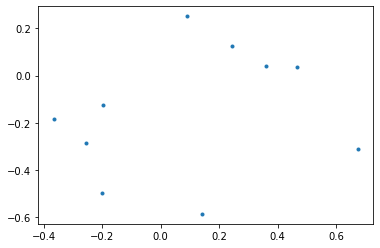

In [5]:

def create_x(x_dim,n):
    return np.random.randn(n,x_dim)

def fake(x_dim, n, generator):
    x = create_x(x_dim, n)   
    y = generator.predict(x)       
    return y,np.zeros((n,1))

x,y = fake(x_dim, 10, generator)
plt.plot(x[:,0], x[:,1],'.')

위의 코드를 실행해보면 생성된 초기 모방데이터가 얼마나 엉망인지 알 수 있다. 
<br><br>
### 3. 판별 신경망 (discriminator) 

판별 신경망은 실제데이터 및 모방데이터를 입력으로 받은 후에 어느쪽이 진짜인지를 판별하는 기능을 갖는다. 위의 예제의 경우 가장 단순한 형태의 신경망으로도 이것이 구성 가능하다. 

이때 입력은 x,y 의 좌표값이므로 2 가 되며 출력은 이것이 진짜인지 아닌지 0,1 로 판별하는 단일 값을 갖는다. 



In [6]:
discriminator = Sequential()
discriminator.add(Dense(25, activation='relu', input_dim=2))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


### 4. 전체 망(GAN) 과 학습 과정

GAN은 모방신경망 -> 판별 신경망을 순차적으로 이어서 생성한다. 



In [7]:
discriminator.trainable = False
model = Sequential()
model.add(generator)    
model.add(discriminator)
model.compile(loss='binary_crossentropy', optimizer='adam')

model.summary()

이제 단일 학습이 어떤 식으로 이루어지는지 간단히 살펴보도록 하겠다. 



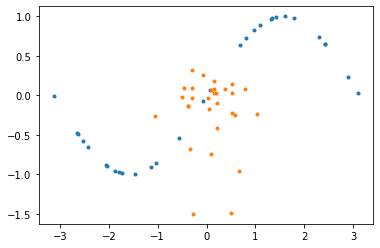

In [8]:
n = 30

# 실제와 모방 데이터 생성
rx,ry = real(n)
fx,fy = fake(x_dim, n, generator)

plt.plot(rx[:,0],rx[:,1],'.')
plt.plot(fx[:,0],fx[:,1],'.')

# 판별망 학습
discriminator.train_on_batch(rx,ry)
discriminator.train_on_batch(fx[:,:2],fy)
    
x = create_x(x_dim,n)
y = np.ones((n,1))

# 전체 신경망 학습 = 모방신경망 학습
model.train_on_batch(x,y)
plt.show()

판별망 학습 -> 모방 신경망 학습으로 반복된다. 전체 학습시 위에서 discriminator.trainable = False 코드를 통해 판별망의 학습을 꺼두었으므로 개별 학습이 아닌 전체 학습에서는 판별신경망이 아닌 모방신경망의 학습이 이뤄지게 된다. 

이제 이것을 반복함으로서 모방 데이터의 변화를 보도록 하겠다. 

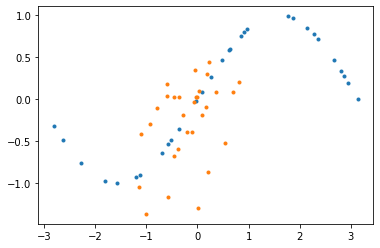

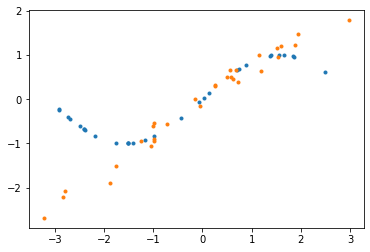

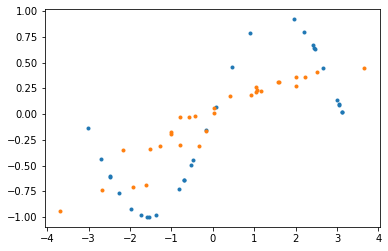

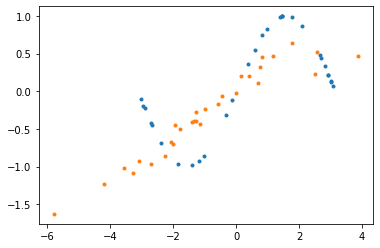

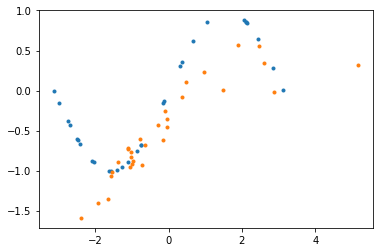

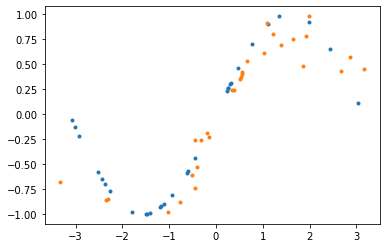

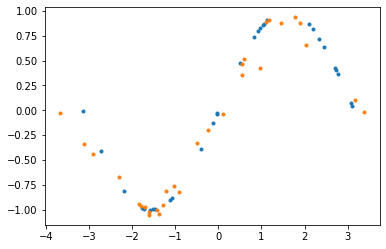

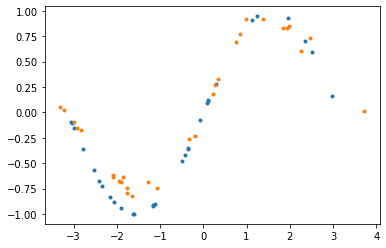

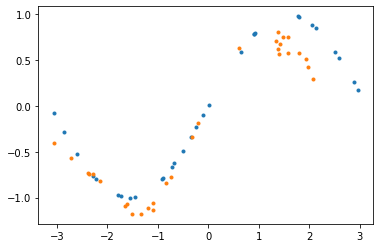

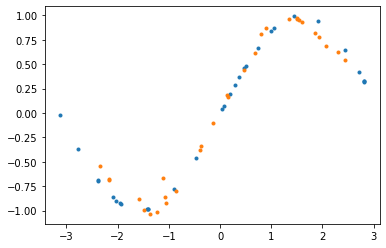

In [9]:
epochs , n = 10000, 30

for i in range(epochs):
  # 실제와 모방 데이터 생성
  rx,ry = real(n)
  fx,fy = fake(x_dim, n, generator)

  # 시각화는 1000 번마다 
  if i % 1000 == 0 : 
    plt.plot(rx[:,0],rx[:,1],'.')
    plt.plot(fx[:,0],fx[:,1],'.')
    plt.show()


  # 판별망 학습
  discriminator.train_on_batch(rx,ry)
  discriminator.train_on_batch(fx[:,:2],fy)
      
  x = create_x(x_dim,n)
  y = np.ones((n,1))

  # 전체 신경망 학습 = 모방신경망 학습
  model.train_on_batch(x,y)


<br><br><hr>

## Mnist Dataset 모방

이번에는 GAN을 이용한 이미지 모방의 가장 단순한 예제로 Mnist Data 모델을 모방해보도록 하겠다.  



### 1. Mnist Data 읽어오기 

Mnist 데이터는 Keras 에서 기본으로 제공하기 때문에 다음과 같이 간단히 읽어올 수 있다.  하지만 전체 이미지 60000 개는 수업시간에 학습하기에는 지나치게 크기 때문에 정확성을 희생하더라도 과감하게 100개만 사용하기로 하겠다. 


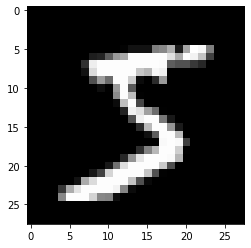

(100, 28, 28, 1) image size: 100


In [21]:
import keras
import tensorflow as tf
import matplotlib.pyplot as plt

(train_images, train_labels), (_, _) = keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

train_images = train_images[:100]
train_labels = train_labels[:100]

BUFFER_SIZE = 100
BATCH_SIZE = 16
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


plt.imshow(train_images[0][:,:,0], cmap = 'gray')
plt.show()
print(train_images.shape, "image size:", train_images.shape[0])

### 2. Generator 생성

이미지를 생성할 경우 Conv2DTranpose 라는 레이어를 사용하는데 이는 Conv2D의 역 형태로 노드로부터 이미지로 데이터를 크게해주는 upscaling 효과를 갖고 있으며 필터의 가중치로 피드백을 받는다. 현재 Mnist 데이터에 효율적으로 알려진 Generator 하나를 사용해 보도록 하겠다. 


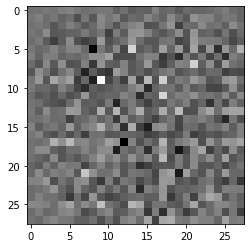

In [24]:
from keras import layers 
import tensorflow as tf
tf.keras.backend.clear_session()

# Generator 정의
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # 주목: 배치사이즈로 None이 주어집니다.

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model


generator = make_generator_model()

# 더미 입력값
noise = tf.random.normal([1, 100])

# 이미지 실제로 생성해보기 
img = generator(noise, training=False)
plt.imshow(img[0, :, :, 0], cmap='gray')

### 3. Discriminator 생성

Discriminator 는 사실 대부분 지금까지 수업시간에 학습해온 분류기와 동일하다. 위의 sin(x)의 예에서는 가장 단순한 순차신경망이 사용되었고 이번에는 입력이 이미지가 되므로 역시 간단한 합성곱 신경망(Conv2D)를 사용하면 된다. 

In [31]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()
decision = discriminator(img)
print (decision)

tf.Tensor([[0.00118784]], shape=(1, 1), dtype=float32)


### 4. loss function 정의 

이 예제에서는 loss function을 따로 정의해 사용한다.  실제이미지는 tf.ones_like 으로 모방 이미지는 tf.zeros_like 으로 텐서를 만들어 사용하는데 원 소스가 tensorflow 쪽 개발자라 그런듯 하다. 



In [25]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### 5. train step 과 train 정의 

Train은 학습의 코어부분과 시각화 부분으로 나뉘는데 train_step 은 학습을, generate_images 는 결과를 이미지화시키는 코드이다. 


In [42]:
from IPython import display

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


def generate_images(model, epoch, test_input):
  # `training`이 False로 맞춰진 것을 주목하세요.
  # 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다. 
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


위에서 @tf.function 이라는 특수 구문을 사용하는데 조사결과 이는 다음 function 을 컴파일해서 최적화 시키는 구문이라고 한다. Train_step이 가장 부하가 큰 부분이라 최적화시키는 코드가 들어간다고 보면 된다.  이제 이 둘을 조합한 전체 트레이닝 코드는 다음과 같다. 


In [44]:
import time
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:            
            train_step(image_batch)

        # GIF를 위한 이미지를 바로 생성합니다.
        display.clear_output(wait=True)
        generate_images(generator, epoch + 1, seed)

        print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # 마지막 에포크가 끝난 후 생성합니다.
    display.clear_output(wait=True)
    generate_images(generator, epochs, seed)

### 6. 학습 실행해보기 

이제 이를 실행하면 모방이미지가 생성되어 가는 과정을 볼 수 있을 것이다. nose_dim은 더미 입력값의 크기이며 , num_exam 은 랜덤생성되는 이미지의 갯수이다. 여기서 학습데이터는 학습후에 같은 더미입력을 통해 모방넷이 변하는 과정을 출력하기 위해 seed 라는 고정 더미 입력값을 사용한다. 

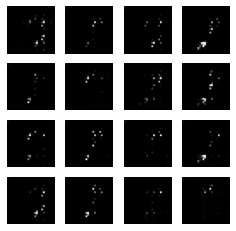

 에포크 67 에서 걸린 시간은 0.45471930503845215 초 입니다
Time for epoch 67 is 0.4547853469848633 sec


In [ ]:
EPOCHS = 1000
noise_dim = 100
ex_num = 16

seed = tf.random.normal([ex_num, noise_dim])

train(train_dataset, EPOCHS)
